In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhLX8-NL5IZlRiZBoGtWt-Oy1adlcdVbGlRBo0Q6pytyZIynuWbD3M
Mounted at /content/drive


In [ ]:
!pip3 install neurite
%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

     |████████████████████████████████| 86 kB 2.9 MB/s 
/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN_archive.ipynb	  prototype.py
 affineRegNN.ipynb		  __pycache__
 affineTrainingData		  test_data
 affine_training_data_gen.ipynb   test_model.png
 basic_unet.png			  test.png
 checkpoints			  utils.py
 generate_data2.m		 'VoxelMorph Demo.ipynb'
 layers.py			  VoxelMorphNetworkStructure1.png
 MRNet				  VoxelMorphNetworkStructure2.png


In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
# import scipy
import time
from tqdm.notebook import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random
from keras import backend as K

In [ ]:
import layers as custom_layers

In [ ]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Num GPUs Available:  1


In [ ]:
# File Paths
# imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
# MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'
MRI_Path = "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration/test_data/{}.npy"

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [ ]:
trainDataPath = "./affineTrainingData/affine{}.npz"
trainDataSize = 2000
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = fixedImg / np.max(fixedImg)
fixedImg = np.expand_dims(fixedImg, axis=-1)
fixedImg = np.expand_dims(fixedImg, axis=0)

def data_generator(batchSize = 1, trainDataSize=2000):
    assert batchSize > 0
    if batchSize == 1:
        while True:
            idx = random.randrange(trainDataSize)
            inputObj = np.load(trainDataPath.format(idx))
            movingImg = inputObj['img']
            movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = np.expand_dims(movingImg, axis=0)
            imgPair = np.concatenate([movingImg, fixedImg], axis=4)

            tgtAffineTrf = inputObj['trf']
            tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
            
            yield (imgPair, [fixedImg, tgtAffineTrf])
    else:
        while True:
            imgPairs = []
            fixedImgs = []
            tgtAffineTrfs = []
            for _ in range(batchSize):
                idx = random.randrange(trainDataSize)
                inputObj = np.load(trainDataPath.format(idx))
                movingImg = inputObj['img']
                movingImg = np.expand_dims(movingImg, axis=-1)
                movingImg = np.expand_dims(movingImg, axis=0)
                imgPair = np.concatenate([movingImg, fixedImg], axis=4)

                tgtAffineTrf = inputObj['trf']
                tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)

                imgPairs.append(imgPair)
                fixedImgs.append(fixedImg)
                tgtAffineTrfs.append(tgtAffineTrf)
            
            imgPairs = np.concatenate(imgPairs, axis=0)
            fixedImgs = np.concatenate(fixedImgs, axis=0)
            tgtAffineTrfs = np.concatenate(tgtAffineTrfs, axis=0)
            yield (imgPairs, [fixedImgs, tgtAffineTrfs])

### Explore data

In [ ]:
# range 0~1
imgPair.max()

1.0000001192092896

In [ ]:
## default img diff
dg = data_generator()
for x in dg:
    break
imgPair, [fixedImg, tgtAffineTrf] = x
imgPair.shape # (1, 52, 256, 256, 2)

((imgPair[0,..., 0] - imgPair[0,..., 1])**2).mean()

0.04952973978294321

In [ ]:
# check mean trf
def data_generator(batchSize = 1):
    # TODO: Batchify the funciton.
    for idx in range(2000):
        # idx = random.randrange(trainDataSize)
        inputObj = np.load(trainDataPath.format(idx))
        movingImg = inputObj['img']
        movingImg = np.expand_dims(movingImg, axis=-1)
        movingImg = np.expand_dims(movingImg, axis=0)
        imgPair = np.concatenate([movingImg, fixedImg], axis=4)

        tgtAffineTrf = inputObj['trf']
        tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
        yield (imgPair, [fixedImg, tgtAffineTrf])

dataGen = data_generator()
trfs = []
for moving_test, (fixed, gt_trf) in tqdm(dataGen, total=2000):
    trfs.append(gt_trf)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
np.mean(trfs, axis=0)

array([[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]])

## NN with labels as fixed images

In [ ]:
# # Get rid of the batch dimension
# imgPairShape = list(fixedImg.shape)[1:]
# # Change the channel dimension to get the image pair shape
# imgPairShape[-1] = 2
# inputs = keras.Input(shape = imgPairShape)
# moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
# fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

# down_depths = [4, 8, 16, 24, 32]
# # up_depths = [2, 16, 32, 16, 3]

# conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation="relu")(moving_input)
# print("conv_0: {}".format(conv_0.shape))
# conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation="relu")(conv_0)
# print("conv_1: {}".format(conv_1.shape))
# filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
# print("filtered_conv_1: {}".format(filtered_conv_1.shape))
# conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation="relu")(filtered_conv_1)
# print("conv_2: {}".format(conv_2.shape))
# filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
# print("filtered_conv_2: {}".format(filtered_conv_2.shape))
# conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation="relu")(filtered_conv_2)
# print("conv_3: {}".format(conv_3.shape))
# conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation="relu")(conv_3)
# print("conv_4: {}".format(conv_4.shape))

# f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation="relu")(fixed_input)
# f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation="relu")(f_conv_0)
# f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
# f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation="relu")(f_filtered_conv_1)
# f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
# f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation="relu")(f_filtered_conv_2)
# f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation="relu")(f_conv_3)

# concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
# print(concat_feats.shape)

# flattened = layers.Flatten()(concat_feats)
# dense_0 = layers.Dense(1024, activation="relu")(flattened)
# dense_1 = layers.Dense(256, activation="relu")(dense_0)
# dense_2 = layers.Dense(64, activation="relu")(dense_1)
# affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# # convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# # print("convTransposed_3: {}".format(convTransposed_3.shape))
# # filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# # print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# # convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# # print("convTransposed_2: {}".format(convTransposed_2.shape))
# # filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# # print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# # convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# # print("convTransposed_1: {}".format(convTransposed_1.shape))
# # convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# # print("convTransposed_0: {}".format(convTransposed_0.shape))
# # deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# # print("deformation_field_pred: {}".format(deformation_field_pred.shape))

# affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# # deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
# print(affine_warped.shape)

conv_0: (None, 47, 113, 113, 4)
conv_1: (None, 42, 98, 98, 8)
filtered_conv_1: (None, 21, 49, 49, 8)
conv_2: (None, 16, 42, 42, 16)
filtered_conv_2: (None, 16, 21, 21, 16)
conv_3: (None, 13, 14, 14, 24)
conv_4: (None, 10, 11, 11, 32)
(None, 10, 11, 11, 64)
(None, 52, 256, 256, 1)


In [ ]:
class affine_trans_rep_to_affine_trans(layers.Layer):
    """
    A custom layer to convert affine transformation representation
    to the 12 affine transformation parameters
    """
    def __init__(self, name="affine_rep2param"):
        super(self.__class__, self).__init__(trainable=False, name=name)
    
    def build(self, input_shape):
        assert input_shape == (18,)
        self.built = True
    
    def get_config(self):
        return super().get_config_copy()
    
    def call(self, input):
        pass

In [ ]:
## Modified model
## 1. use lrelu for all relu
# Get rid of the batch dimension
imgPairShape = list(fixedImg.shape)[1:]
# Change the channel dimension to get the image pair shape
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
lrelu = layers.LeakyReLU(alpha=0.1)

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(conv_3)
print("conv_4: {}".format(conv_4.shape))

f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(fixed_input)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(f_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(f_filtered_conv_2)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(f_conv_3)

concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
print(concat_feats.shape)

flattened = layers.Flatten()(concat_feats)
dense_0 = layers.Dense(1024, activation=lrelu)(flattened)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

conv_0: (None, 47, 113, 113, 4)
conv_1: (None, 42, 98, 98, 8)
filtered_conv_1: (None, 21, 49, 49, 8)
conv_2: (None, 16, 42, 42, 16)
filtered_conv_2: (None, 16, 21, 21, 16)
conv_3: (None, 13, 14, 14, 24)
conv_4: (None, 10, 11, 11, 32)
(None, 10, 11, 11, 64)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
(None, 52, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="combined_model")
model.summary(line_length=150)

Model: "combined_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 52, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem (SlicingOpLambda)       (None, 52, 256, 256)             0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_1 (SlicingOpLambda)     (None, 52, 256, 256) 

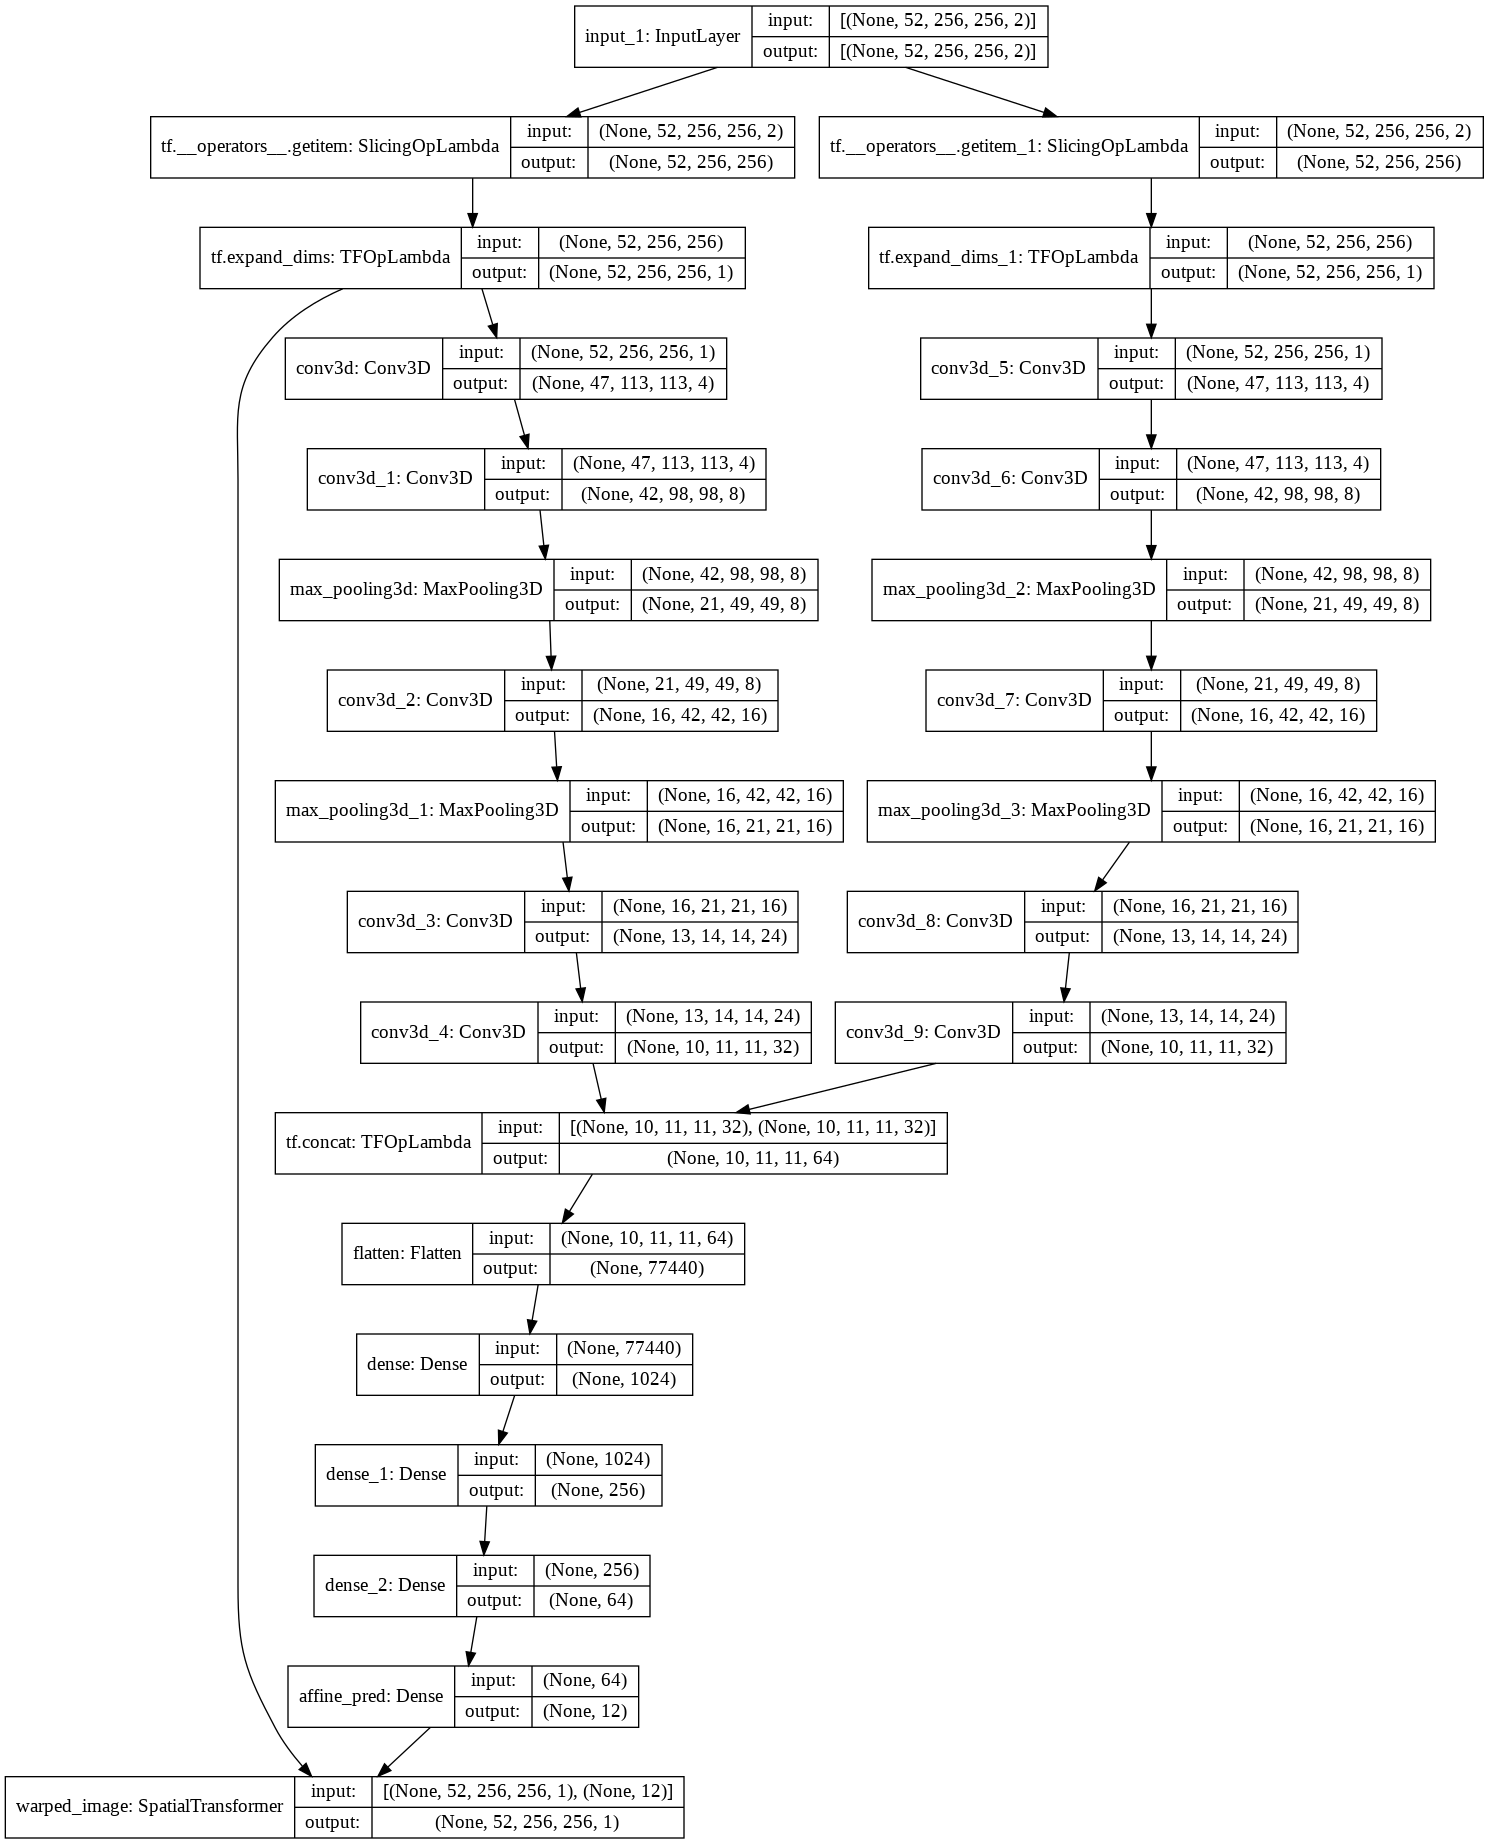

In [ ]:
keras.utils.plot_model(model, "test.png", show_shapes=True)

In [ ]:
# """
# y = (deformed_img, affine_trf)
# """
# def affine_loss(y_actual, y_pred):
#     y_actual = y_actual[0]
#     y_pred = y_pred[0]
#     tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
#     predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
#     tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
#     predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
#     tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
#     predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
#     mse = tf.keras.losses.MeanSquaredError()
#     diag_loss = mse(tgtDiag, predDiag)
#     corner_loss = mse(tgtCorner, predCorner)
#     translation_loss = mse(tgtTranslation, predTranslation)
#     return corner_loss * 10 + diag_loss * 10 + translation_loss

#### Train

In [ ]:
## Training 
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

output_dir = os.path.join("checkpoints", time.strftime("%m_%d_%H-%M-%S"))
save_callback = ModelCheckpoint(os.path.join(output_dir, "{epoch:02d}.h5"),
                                # monitor='val_warped_image_mean_squared_error',
                                save_best_only=True,
                                )

# model.compile(optimizer=optimizer,
#               loss={"warped_image":"mean_squared_error", "affine_pred":"mean_squared_error"},
#             #   loss_weights={"warped_image":1, "affine_pred":1},
#               run_eagerly=True)
model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred":"mean_absolute_error"},
            #   loss_weights={"warped_image":1, "affine_pred":1},
            #   metrics={"warped_image":"mean_squared_error"},
              run_eagerly=True)

In [ ]:
dataGen = data_generator(batchSize=8)
val_dataGen = data_generator(batchSize=8)

In [ ]:
# model.fit(dataGen, epochs=20, steps_per_epoch=trainDataSize, callbacks=[save_callback])
trainDataSize=20
valDataSize=4
epochs=50
os.makedirs(output_dir)

results = model.fit(dataGen, epochs=epochs, steps_per_epoch=trainDataSize, 
                    validation_data=val_dataGen, validation_steps=valDataSize,
                    callbacks=[save_callback])

model.save(os.path.join(output_dir, "final_model.h5"))
with open(os.path.join(output_dir, "results.pkl"), "wb") as f:
    pickle.dump(results.history, f)

Epoch 1/50
20/20 [==============================] - 312s 11s/step - loss: 2.7117 - warped_image_loss: 0.0838 - affine_pred_loss: 2.6279 - val_loss: 2.1217 - val_warped_image_loss: 0.0898 - val_affine_pred_loss: 2.0319
Epoch 2/50
20/20 [==============================] - 230s 12s/step - loss: 1.9583 - warped_image_loss: 0.0813 - affine_pred_loss: 1.8770 - val_loss: 1.9341 - val_warped_image_loss: 0.0749 - val_affine_pred_loss: 1.8591
Epoch 3/50
20/20 [==============================] - 229s 12s/step - loss: 1.6775 - warped_image_loss: 0.0706 - affine_pred_loss: 1.6069 - val_loss: 1.6557 - val_warped_image_loss: 0.0671 - val_affine_pred_loss: 1.5886
Epoch 4/50
20/20 [==============================] - 229s 11s/step - loss: 1.6154 - warped_image_loss: 0.0706 - affine_pred_loss: 1.5448 - val_loss: 1.5852 - val_warped_image_loss: 0.0542 - val_affine_pred_loss: 1.5310
Epoch 5/50
20/20 [==============================] - 231s 12s/step - loss: 1.5358 - warped_image_loss: 0.0585 - affine_pred_loss:

In [ ]:
def plot_accuracy(history, metric_name="warped_image_mean_squared_error"):
    assert metric_name in history and "val_"+metric_name in history, "history doesn't contain such metric"
    plt.plot(history[metric_name])
    plt.plot(history['val_' + metric_name])
    plt.title(f"Train and val {metric_name}")
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val']) #, loc='upper left'
    plt.show()

def plot_loss(history, ylim=None):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if ylim:
        plt.ylim(ylim)
    plt.legend(['train', 'val'])
    plt.show()

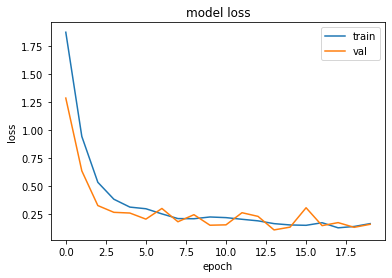

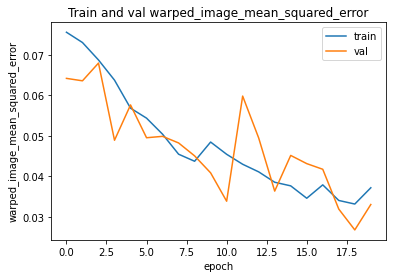

In [ ]:
## model 1
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_mean_squared_error")

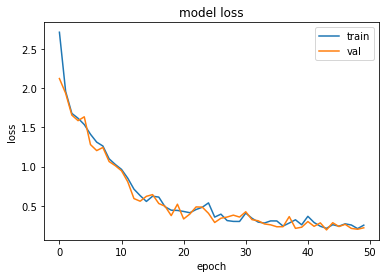

In [ ]:
## model 2
result_path = "checkpoints/08_15_17-40-23/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)

plot_loss(history, ylim=None)
# plot_accuracy(history, metric_name="warped_image_mean_squared_error")

## Test model (output == warpedImg)

In [ ]:
!ls checkpoints

08_14_22-59-55	08_14_23-59-03	08_15_09-51-38
08_14_23-05-06	08_15_07-38-34	08_15_17-40-23


In [ ]:
# dataGen = data_generator()
# testModel = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred])

# testModel.load_weights('./checkpoints/trial/17.h5')
# testModel.load_weights('./checkpoints/08_14_23-05-06/03.h5')
# testModel.load_weights('./checkpoints/08_14_23-59-03/16.h5')
# testModel.load_weights('./checkpoints/08_15_07-38-34/40.h5')

# testModel = model

dataGen = data_generator(batchSize=8)
testModel = keras.models.load_model('./checkpoints/08_15_17-40-23/44.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)})

#### Debug result for modified model 2

Trained with:  
* 50 epoch, 20 iterations/epoch, 8 batchsize/iter
* lr 0.0001, 
* include warped_image as loss
* lrelu, alpha = 0.1

Result: 
* doesn't converge to a fixed feature layer and trans mat
* the translation params are good
* rotation and scaling need improvement -> change representation?

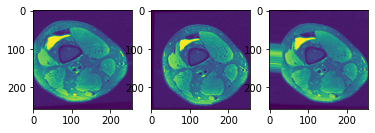

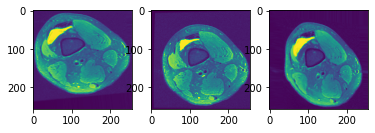

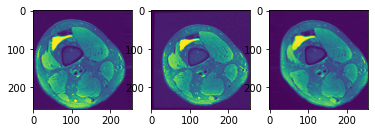

[[ 8.93218793e-01  3.42609129e-02  4.28068289e-02 -1.76180484e+00
  -3.46399252e-02  9.92709024e-01 -7.17195191e-02 -9.61928694e+00
  -5.63590106e-02  7.84584504e-02  1.11320718e+00 -2.59775060e+01]
 [ 9.44940138e-01  1.86078190e-02  3.42722002e-02 -3.59753169e+00
  -1.54142819e-02  9.85179166e-01 -1.09898457e-01 -2.76767038e+01
  -4.20590486e-02  1.21351582e-01  1.09374930e+00 -1.88961313e+01]
 [ 9.09621867e-01  1.88695070e-02  2.68037758e-02 -1.41084785e+00
  -2.11047806e-02  1.10058635e+00 -5.85795026e-02 -3.85162351e+00
  -3.16907427e-02  5.45893646e-02  1.03703741e+00 -2.10666452e+01]]
tf.Tensor(
[[ 9.4776344e-01  5.6595486e-02  9.0542324e-03 -1.7798660e+00
  -1.8876164e-01  1.0258607e+00 -8.9500539e-02 -9.7862129e+00
  -1.0625828e-01  1.9445425e-03  1.0781703e+00 -2.5575834e+01]
 [ 9.5153880e-01  7.4212119e-02 -1.0637303e-01 -3.4757121e+00
   8.1716381e-02  9.4315702e-01 -1.1552129e-01 -2.8364544e+01
  -1.5036933e-01  9.4199711e-03  1.2188196e+00 -1.8603912e+01]
 [ 9.5704603e-01 

In [ ]:
"""
[[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]]
"""
moving_test, label_test = next(dataGen)
num_show = 3
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test)

for i in range(num_show):
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(moving_test[i,1,:,:,0])
    axes[1].imshow(moving_test[i,1,:,:,1])
    axes[2].imshow(warped_test[i,1,:,:,0])
    plt.show()

print(gt_trf)
print(affine_pred_test)

#### Debug result for modified model 1
Trained with:  
* 20 epoch, 100 iterations/epoch, 8 batchsize/iter
* lr 0.0001
* does not include warped_image as loss
* lrelu, alpha = 0.1? 0.01?

Result: converge to a fixed feature layer and trans mat

[[  1.01307884   0.04695047   0.05647605  -3.06879812  -0.04671235
    1.07687879  -0.05731049  -0.30486862  -0.05709557   0.04982545
    0.98277023 -17.79652506]
 [  1.01553937   0.04557165   0.04181016  -6.26352387  -0.04745814
    1.11552157  -0.06315577 -15.07738272  -0.04337833   0.05444641
    0.99428441 -21.08516239]
 [  1.16565734   0.02999379   0.04155809  -1.41275025  -0.02162385
    0.99185049  -0.10932547 -12.91094143  -0.0350791    0.0997521
    0.91193496  -2.26271549]]
tf.Tensor(
[[  0.9247373    0.11367744   0.05949632  -3.6759      -0.09295747
    0.9371287   -0.06350692  -9.7160015   -0.06959302   0.06688026
    0.85883665 -16.67128   ]
 [  0.9479564    0.10165794   0.07214145  -3.7683585   -0.09284243
    0.969339    -0.05306562  -9.9907055   -0.07557572   0.06122331
    0.87892294 -17.10369   ]
 [  0.9869215    0.1143422    0.07018188  -3.929672    -0.09881708
    1.001384    -0.0471619  -10.410757    -0.06640584   0.06057689
    0.9249784  -17.80829   ]], shape=(3,

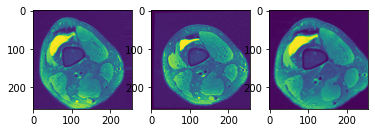

In [ ]:
"""
[[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]]
"""
moving_test, label_test = next(dataGen)
num_show = 3
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test)

fig, axes = plt.subplots(1,3)
axes[0].imshow(moving_test[0,1,:,:,0])
axes[1].imshow(moving_test[0,1,:,:,1])
axes[2].imshow(warped_test[0,1,:,:,0])

print(gt_trf)
print(affine_pred_test)

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()

In [ ]:
## 3 view hidden layer outputs values
## https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
inp = testModel.input                                           # input placeholder
names = [layer.name for layer in testModel.layers]
outputs = [layer.output for layer in testModel.layers]          # all layer outputs
functor = K.function([inp], outputs)   # evaluation function

# Testing
moving_test, label_test = next(dataGen)
num_show = 3
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
# (warped_test, affine_pred_test) = testModel(moving_test)
layer_outs = functor([moving_test])
print("Total:", len(layer_outs))
# print(layer_outs[-1].shape, layer_outs[-1])
num_display = 32
last_layer = -26
for i in range(-2,last_layer,-1):
    print(f"==> Layer {i}: {names[i]}", layer_outs[i].shape)
    if layer_outs[i][0].size <= num_display:
        print(f"<{num_display}", layer_outs[i].reshape((num_show, -1)))
    else:
        print(f">{num_display}", layer_outs[i].reshape((num_show, -1))[:, :num_display])
flat1 = layer_outs[-6]

Total: 26
==> Layer -2: affine_pred (3, 12)
<32 [[  0.93072045   0.10536972   0.0678002   -3.708314    -0.09176931
    0.9486078   -0.05230941  -9.80652     -0.06855953   0.06006256
    0.8634623  -16.797777  ]
 [  0.9245379    0.10793729   0.06425587  -3.6796176   -0.09175465
    0.9401885   -0.05818095  -9.728274    -0.06912465   0.0630937
    0.8562052  -16.67839   ]
 [  0.89828247   0.11130938   0.05677251  -3.5748327   -0.09092507
    0.91088504  -0.0635468   -9.432624    -0.06706191   0.06607191
    0.8303194  -16.192625  ]]
==> Layer -3: dense_5 (3, 64)
>32 [[-4.785629   -2.229453   -2.1108272  -2.5719826  -0.9488164  -5.0714436
  -2.284449   -2.8829417  -0.6975332  -3.6147463  -2.0171328  -1.9428521
  -2.9763026  -1.8965143  -5.4362607  -7.9871006  -7.7970767  -1.2598281
  -1.7856145  -2.8420324  -6.613984   -2.5303967  -0.46074018 -4.6359496
  -1.697007   -2.1841981  -1.4382288  -3.7763968  -7.4854584  -2.7062917
  -1.8627506  -3.7713747 ]
 [-4.7499213  -2.2135408  -2.0939445 

#### Debug result for original model

Process:
1. a random initialized model produces diff outputs
2. check weight: all trained weights are not all zeros
3. check output of trained hidden layers: 
    - dense layers receive the same input !
    - the feature encoding of the moving image converges to a fixed feature map (lots of zeros) 
    - dying Relu problem? try to change activation?
    - rotation representation problem?
    - not enough iterations?
4. change relu to lrelu(alpha=0.01 or 0.1), still converge to a fixed feature maps after some conv3d and maxpool layers
    - not problem of relu but problem of rotation representation?
    - test data generated without rotation?


In [ ]:
for layer in testModel.layers: 
    # print(layer.get_config(), layer.get_weights())
    ### 2 check weight
    if "dense" in layer.name or "affine_pred" in layer.name or "conv" in layer.name:
        print("----", layer.name, "weight_shape:", len(layer.get_weights()), layer.get_weights()[0].shape, layer.get_weights()[1].shape)
        print(np.allclose(layer.get_weights()[0], 0), np.allclose(layer.get_weights()[1], 0))
    # if "dense" in layer.name or "affine_pred" in layer.name:
        # print(layer.get_weights())
        # print(layer.input.shape, layer.output.shape)
        # print(layer.output)

---- conv3d_20 weight_shape: 2 (6, 32, 32, 1, 4) (4,)
False False
---- conv3d_25 weight_shape: 2 (6, 32, 32, 1, 4) (4,)
False False
---- conv3d_21 weight_shape: 2 (6, 16, 16, 4, 8) (8,)
False False
---- conv3d_26 weight_shape: 2 (6, 16, 16, 4, 8) (8,)
False False
---- conv3d_22 weight_shape: 2 (6, 8, 8, 8, 16) (16,)
False False
---- conv3d_27 weight_shape: 2 (6, 8, 8, 8, 16) (16,)
False False
---- conv3d_23 weight_shape: 2 (4, 8, 8, 16, 24) (24,)
False False
---- conv3d_28 weight_shape: 2 (4, 8, 8, 16, 24) (24,)
False False
---- conv3d_24 weight_shape: 2 (4, 4, 4, 24, 32) (32,)
False False
---- conv3d_29 weight_shape: 2 (4, 4, 4, 24, 32) (32,)
False False
---- dense_6 weight_shape: 2 (77440, 1024) (1024,)
False False
---- dense_7 weight_shape: 2 (1024, 256) (256,)
False False
---- dense_8 weight_shape: 2 (256, 64) (64,)
False False
---- affine_pred weight_shape: 2 (64, 12) (12,)
False False


In [ ]:
## 3 view hidden layer outputs values
## https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
inp = testModel.input                                           # input placeholder
names = [layer.name for layer in testModel.layers]
outputs = [layer.output for layer in testModel.layers]          # all layer outputs
functor = K.function([inp], outputs)   # evaluation function

# Testing
moving_test, label_test = next(dataGen)
# (warped_test, affine_pred_test) = testModel(moving_test)
layer_outs = functor([moving_test])
print("Total:", len(layer_outs))
# print(layer_outs[-1].shape, layer_outs[-1])
num_display = 126
last_layer = -26
for i in range(-2,last_layer,-1):
    print(f"==> Layer {i}: {names[i]}", layer_outs[i].shape)
    if layer_outs[i].size <= num_display:
        print(f"<{num_display}", layer_outs[i].flatten())
    else:
        print(f">{num_display}", layer_outs[i].flatten()[:num_display])
flat1 = layer_outs[-6]

Total: 26
==> Layer -2: affine_pred (1, 12)
<126 [ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
 -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
  9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]
==> Layer -3: dense_8 (1, 64)
<126 [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         3.0663462
  0.         0.         0.         0.         4.0462074  1.8267351
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         6.129323   0.         0.
 10.135203  10.120459   0.         0.         0.         0.
  0.         0.         4.7288237  4.4399085  0.         0.
 12.414728   0.         0.         4.0622296  0.         0.
  0.         0.         0.         0.         0.         0.
  0.        10.491759   0.         6.56872    0.         2.8780391
  0.         0.         4.017658   2.296172 ]
==> Layer -4: dense_7 (1, 256)
>126 [2.6012566  7.3405604  0.    

In [ ]:
# Testing
moving_test, label_test = next(dataGen)
layer_outs = functor([moving_test])
print("Total:", len(layer_outs))
for i in range(-2,last_layer,-1):
    print(f"==> Layer {i}: {names[i]}", layer_outs[i].shape)
    if layer_outs[i].size <= num_display:
        print(f"<{num_display}", layer_outs[i].flatten())
    else:
        print(f">{num_display}", layer_outs[i].flatten()[:num_display])
flat2 = layer_outs[-6]

Total: 26
==> Layer -2: affine_pred (1, 12)
<126 [ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
 -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
  9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]
==> Layer -3: dense_8 (1, 64)
<126 [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         3.0663462
  0.         0.         0.         0.         4.0462074  1.8267351
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         6.129323   0.         0.
 10.135203  10.120459   0.         0.         0.         0.
  0.         0.         4.7288237  4.4399085  0.         0.
 12.414728   0.         0.         4.0622296  0.         0.
  0.         0.         0.         0.         0.         0.
  0.        10.491759   0.         6.56872    0.         2.8780391
  0.         0.         4.017658   2.296172 ]
==> Layer -4: dense_7 (1, 256)
>126 [2.6012566  7.3405604  0.    

In [ ]:
np.allclose(flat1, flat2)

True

In [ ]:
"""
[[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]]
"""
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)

fig, axes = plt.subplots(1,3)
axes[0].imshow(moving_test[0,1,:,:,0]) # M
axes[1].imshow(moving_test[0,1,:,:,1]) # F
axes[2].imshow(warped_test[0,1,:,:,0])

print(label_test[1])
print(affine_pred_test)

[[  0.95796721   0.06759928   0.03561585  -4.08532835  -0.06171287
    0.92737492  -0.10026351  -8.25192058  -0.04846884   0.11427287
    1.08678564 -27.43916151]]
tf.Tensor(
[[ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
  -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
   9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]], shape=(1, 12), dtype=float32)


In [ ]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)

fig, axes = plt.subplots(1,3)
axes[0].imshow(moving_test[0,1,:,:,0])
axes[1].imshow(moving_test[0,1,:,:,1])
axes[2].imshow(warped_test[0,1,:,:,0])

print(label_test[1])
print(affine_pred_test)

[[  0.88378472   0.0575234    0.06490466  -3.78928535  -0.05013974
    0.88283919  -0.0997027  -23.42505913  -0.07183986   0.0967141
    0.89250367 -22.70701654]]
tf.Tensor(
[[ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
  -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
   9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]], shape=(1, 12), dtype=float32)


In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()

#### Old debug result

In [ ]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)
print(label_test[1])
print(affine_pred_test)

[[ 9.97783354e-01  2.81807946e-02  5.97546391e-02 -2.36656929e+00
  -1.86507086e-02  1.03671288e+00 -1.77492932e-01 -2.16959668e+01
  -6.78998079e-02  1.78480907e-01  1.04961833e+00 -2.92642264e+01]]
tf.Tensor(
[[ 9.3246776e-01 -9.5513612e-03  8.3614871e-02 -3.7436948e+00
  -3.2481186e-02  1.0323266e+00 -3.4798801e-02 -1.4669796e+01
  -1.9191064e-02  6.1604641e-02  1.0701416e+00 -1.5027257e+01]], shape=(1, 12), dtype=float32)


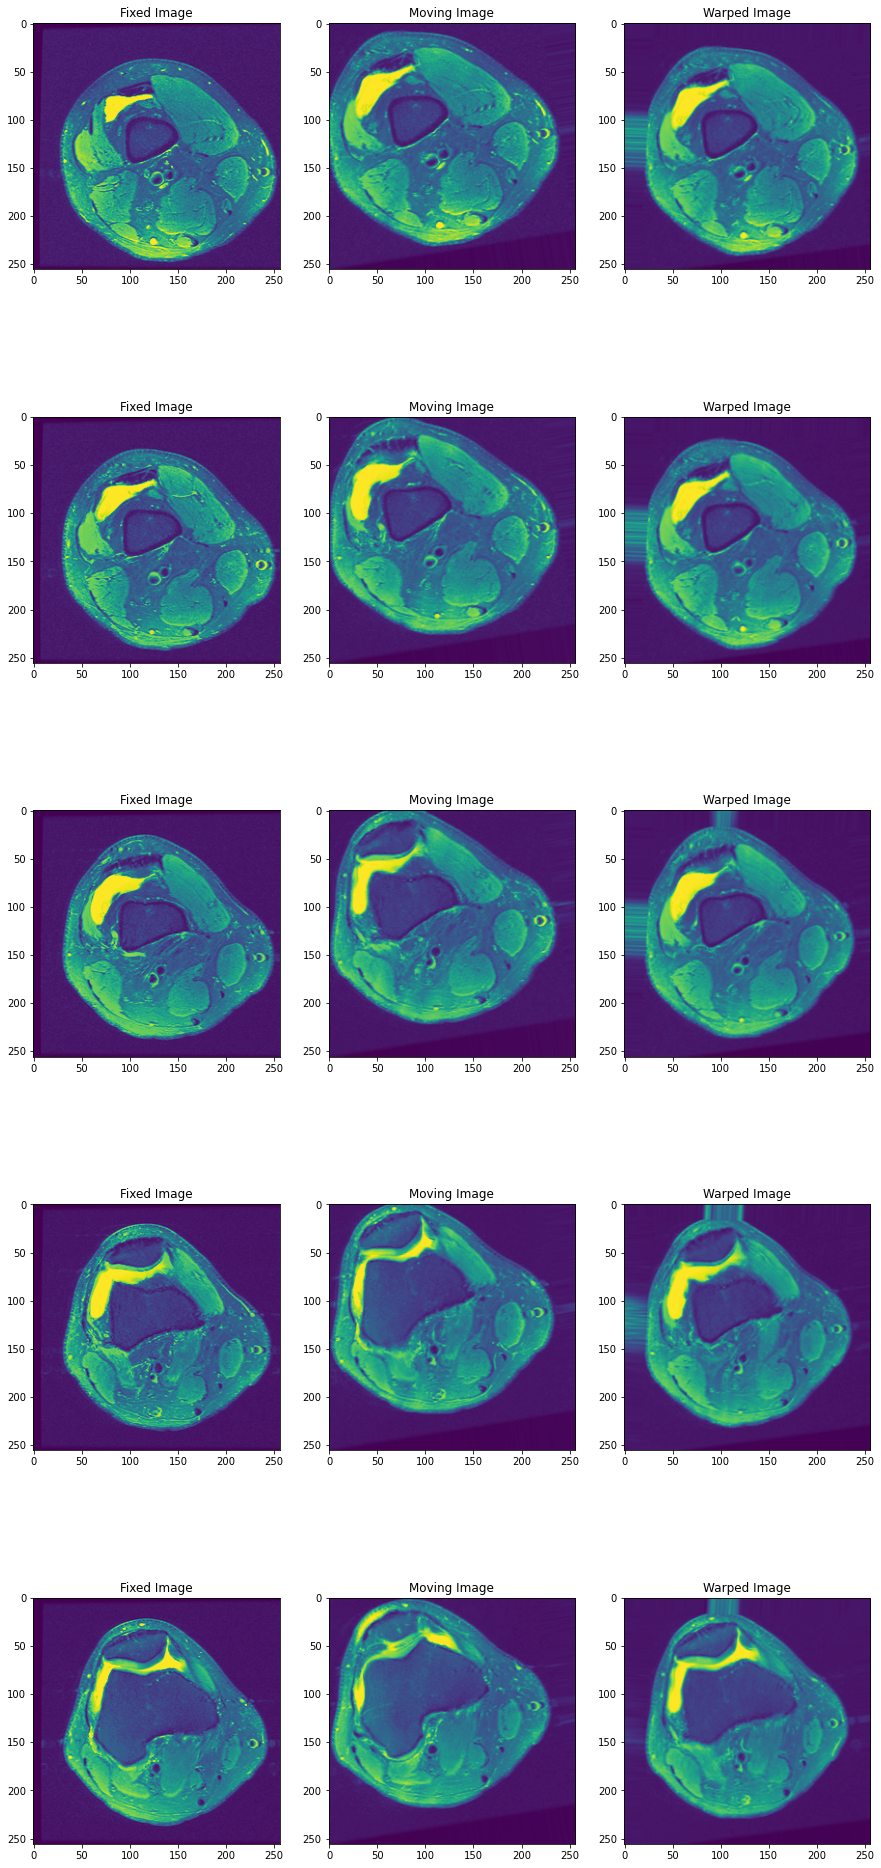

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()